In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import pymysql.cursors
import yfinance as yf
import math
from math import sqrt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, BatchNormalization, TimeDistributed, Flatten, Bidirectional,Dropout, MultiHeadAttention
from pyhht.visualization import plot_imfs
from sklearn.metrics import r2_score
from datetime import datetime,timedelta
from pyhht.emd import EMD
from matplotlib import pyplot
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
from keras_self_attention import SeqSelfAttention
from attention import Attention
from pyhht.emd import EMD
from matplotlib import pyplot
from pyhht.visualization import plot_imfs
from PyEMD import CEEMDAN

In [2]:
class MySQL:
    def __init__(self):
        super(MySQL, self).__init__()

        self.connection = pymysql.connect(
            host="",
            user="",
            password="",
            db="",
            charset='utf8',
            cursorclass=pymysql.cursors.DictCursor
        )

    def connect(self, host, user, password, db):
        self.connection = pymysql.connect(
            host=host,
            user=user,
            password=password,
            db=db,
            charset='utf8',
            cursorclass=pymysql.cursors.DictCursor
        )

    def reconnect(self, DB_CONFIG):
        self.connection = pymysql.connect(
            host=DB_CONFIG['host'],
            user=DB_CONFIG['user'],
            password=DB_CONFIG['password'],
            db=DB_CONFIG['db'],
            charset='utf8',
            cursorclass=pymysql.cursors.DictCursor
        )

    def execute(self, sql):
        connection = self.connection
        cursor = connection.cursor()
        result = cursor.execute(sql)
        connection.commit()
        response = {
            'result': result,
            'sn': cursor.lastrowid
        }

        return response

    def query(self, state):
        connection = self.connection
        with connection.cursor() as cursor:
            cursor.execute(state)
            result = cursor.fetchall()

        return result

    def ping(self):
        self.connection.ping(reconnect=True)

    def close(self):
        self.connection.close()
#整段時間區間
train_begin_date = '2019-01-01'
train_end_date = '2021-01-01'
predict_begin_date = '2021-05-01'
predict_end_date = '2021-05-31'

# sql = "SELECT * from demand order by dateㄍtime desc limit 30000"
sql = '''SELECT  `demand_quarter`, `datetime`
                FROM `demand_with_weather_data` 
                WHERE `datetime` >= '{}' AND `datetime` < '{}'
                ORDER BY `datetime` '''.format(train_begin_date, predict_end_date)
dbh = MySQL()
all_data = dbh.query(sql)
train_sql = '''SELECT  `demand_quarter`, `datetime`
                FROM `demand_with_weather_data` 
                WHERE `datetime` >= '{}' AND `datetime` < '{}'
                ORDER BY `datetime` '''.format(train_begin_date, train_end_date)
train_data = dbh.query(train_sql)
predict_sql = '''SELECT  `demand_quarter`, `datetime`
                FROM `demand_with_weather_data` 
                WHERE `datetime` >= '{}' AND `datetime` < '{}'
                ORDER BY `datetime` '''.format(predict_begin_date, predict_end_date)
predict_data = dbh.query(predict_sql)
dbh.close()
all_df = pd.DataFrame(all_data)
all_df = all_df.set_index('datetime')
train_df = pd.DataFrame(train_data)
train_df = train_df.set_index('datetime')
predict_df = pd.DataFrame(predict_data)
predict_df = predict_df.set_index('datetime')
# test_df = test_df.set_index('sn')
# predict_df
predict_df

,demand_quarter
datetime,
2021-05-01 00:00:00,156.8
2021-05-01 00:15:00,145.2
2021-05-01 00:30:00,157.2
2021-05-01 00:45:00,137.2
2021-05-01 01:00:00,130.4
...,...
2021-05-30 22:45:00,164.0
2021-05-30 23:00:00,159.2
2021-05-30 23:15:00,153.6


In [3]:
begin_date = '2017-06-08'
end_date = '2022-06-08'
try: 
    conn  =  pymysql.connect ( host = '' ,  user = '' ,  passwd = "" ,  db = '' ) 
    cur  =  conn.cursor() 
    select_sql = '''SELECT `id`, `demand_min`, `demand_quarter`, `Total_value`, `Temperature`, 
                    `humd`, `pres`, `w_DSD`, `w_DIR`, `h_FX`, `24R`, `h_UVI`, `T_Min`, `T_Max`, 
                    `day_of_year`, `data_week`, `data_date`, `data_hour`, `data_minute`, `data_weekday`, 
                    `minutes_of_the_day`, `period_type`, `datetime`
                    FROM `demand_with_weather_data` 
                    WHERE `datetime` >= '{}' AND `datetime` < '{}'
                    ORDER BY `datetime` '''.format(begin_date, end_date)
    result_object = cur.execute(select_sql)
    results_values_list = cur.fetchall()
    result_key_list = [i[0] for i in cur.description]
    
    dataframe = pd.DataFrame(results_values_list)
    dataframe.columns = result_key_list
    timestamp = pd.to_datetime(dataframe.datetime, infer_datetime_format=True).values.astype(float)
    dataframe['timestamp'] = timestamp.tolist()
    dataframe = dataframe.set_index('datetime')
    cur.close () 
    conn.close()
except Exception as e:
    print(e)

In [4]:
dataframe = dataframe.interpolate(method="linear")
dataframe

,id,demand_min,demand_quarter,Total_value,Temperature,humd,pres,w_DSD,w_DIR,h_FX,...,T_Max,day_of_year,data_week,data_date,data_hour,data_minute,data_weekday,minutes_of_the_day,period_type,timestamp
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-08 13:45:00,33,258.0,283.6,254.0,33.0,0.60,1007.0,2.6,210.0,6.0,...,34.0,159,23,2017-06-08,13,45,4,825,2,1.496930e+18
2017-06-08 14:00:00,34,264.0,277.6,268.0,34.0,0.58,1007.0,2.3,250.0,7.0,...,34.0,159,23,2017-06-08,14,0,4,840,2,1.496930e+18
2017-06-08 14:15:00,35,270.0,269.6,286.0,34.0,0.58,1007.0,2.3,250.0,7.0,...,34.0,159,23,2017-06-08,14,15,4,855,2,1.496931e+18
2017-06-08 14:30:00,36,294.0,288.4,301.0,34.0,0.58,1007.0,2.3,250.0,7.0,...,34.0,159,23,2017-06-08,14,30,4,870,2,1.496932e+18
2017-06-08 14:45:00,37,300.0,295.2,289.0,34.0,0.58,1007.0,2.3,250.0,7.0,...,34.0,159,23,2017-06-08,14,45,4,885,2,1.496933e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-07 22:30:00,162960,150.0,152.8,144.0,25.6,0.89,1006.0,2.3,160.0,6.0,...,29.3,158,23,2022-06-07,22,30,2,1350,0,1.654641e+18
2022-06-07 22:45:00,162961,150.0,150.8,153.0,25.7,0.90,1007.0,1.8,170.0,6.0,...,29.3,158,23,2022-06-07,22,45,2,1365,0,1.654642e+18
2022-06-07 23:00:00,162962,132.0,138.4,144.0,25.8,0.90,1007.0,1.7,180.0,6.0,...,29.3,158,23,2022-06-07,23,0,2,1380,0,1.654643e+18


In [5]:
train_df

,demand_quarter
datetime,
2019-01-01 00:00:00,91.6
2019-01-01 00:15:00,94.0
2019-01-01 00:30:00,94.4
2019-01-01 00:45:00,90.8
2019-01-01 01:00:00,91.6
...,...
2020-12-31 22:45:00,88.4
2020-12-31 23:00:00,86.4
2020-12-31 23:15:00,85.2


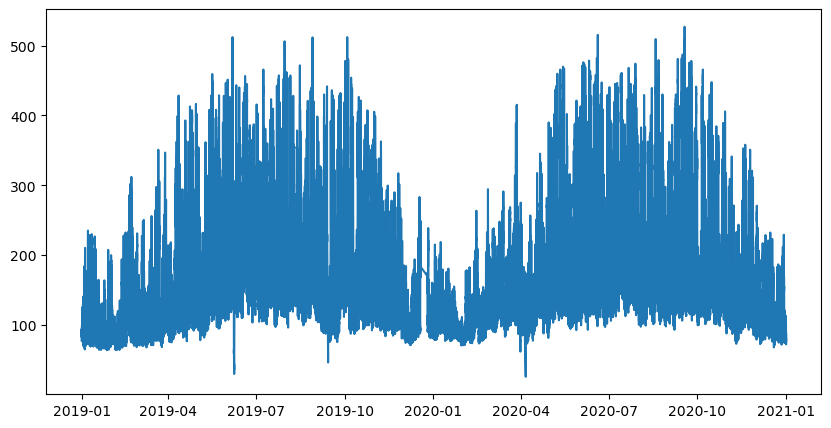

In [6]:
plt.figure(figsize=(10,5))
plt.plot(train_df)

# 將已蒐集的訓練集資料先進行分解

In [12]:
# 生成res的分解
def ceemdan_decompose_res(data):
    ceemdan = CEEMDAN()
#     ceemdan(S: ndarray, T: ndarray | None = None, max_imf: int = -1, progress: bool = False)
    ceemdan.ceemdan(data,max_imf=2)
    imfs, res = ceemdan.get_imfs_and_residue()
    plt.figure(figsize=(12,9))
    plt.subplots_adjust(hspace=0.1)
    plt.subplot(imfs.shape[0]+3, 1, 1)
    plt.plot(data,'r')
    for i in range(imfs.shape[0]):
        plt.subplot(imfs.shape[0]+3,1,i+2)
        plt.plot(imfs[i], 'g')
        plt.ylabel("IMF %i" %(i+1))
        plt.locator_params(axis='x', nbins=10)
        # 在函数前必须设置一个全局变量 IImfs=[]
        IImfs.append(imfs[i])
    plt.subplot(imfs.shape[0]+3, 1, imfs.shape[0]+3)
    plt.plot(res,'g')
    return res

In [16]:
#訓練集的CEEMDAN
ceemdan = CEEMDAN()
start = time.time()
ceemdan.ceemdan(np.array(train_df).ravel(),max_imf=2)
train_imfs, train_res = ceemdan.get_imfs_and_residue()
end = time.time()
print("執行時間：%f 秒" % (end - start))

執行時間：591.340435 秒


In [17]:
# 把訓練集分解的 imf 匯到資料庫 
def Imf_to_Database(df,imf, imf_number): 
    imf_df = pd.DataFrame(imf)
    imf_df.set_index(df.index, inplace=True)
    imf_df = imf_df.rename(columns={0: 'demand'})
    imf_df = imf_df.reset_index()
    connection = pymysql.connect(host = '' ,  user = '' ,  passwd = "", db='')
    cursor = connection.cursor()
    data = imf_df.values.tolist()
    insert_query = '''
    REPLACE INTO imf{} (`datetime`, `demand_IMF{}`)
    VALUES (%s, %s)
    '''.format(imf_number,imf_number)
    cursor.executemany(insert_query, data)
    connection.commit()
    connection.close()

In [112]:
# Imf_to_Database(train_df, train_imfs[0], 1)
# Imf_to_Database(train_df, train_imfs[1], 2)
# Imf_to_Database(train_df, train_imfs[2], 3)
# Imf_to_Database(train_df, train_imfs[3], 4)
# Imf_to_Database(train_df, train_imfs[4], 5)

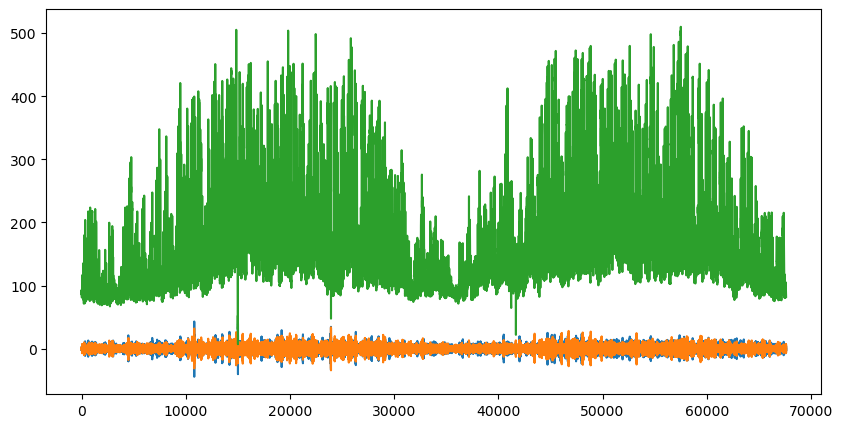

In [41]:
plt.figure(figsize=(10,5))
plt.plot(train_imfs[0])
plt.plot(train_imfs[1])
plt.plot(train_imfs[2])
# plt.plot(train_imfs[3])
# plt.plot(train_imfs[4])

In [20]:
np.array(train_df)

array([[91.6],
       [94. ],
       [94.4],
       ...,
       [85.2],
       [72.4],
       [80.4]])

In [21]:
#測試集的CEEMDAN
start = time.time()
ceemdan.ceemdan(np.array(predict_df).ravel(),max_imf=2)
test_imfs, test_res = ceemdan.get_imfs_and_residue()
end = time.time()
print("執行時間：%f 秒" % (end - start))

執行時間：5.967354 秒


In [22]:
test_imfs

array([[  6.48499899,  -7.04865418,   7.16212851, ...,  -0.65262448,
          0.68652087,  -0.52736179],
       [  6.10403359,   7.63682028,   6.51478731, ...,  -1.52562913,
         -1.6468393 ,  -2.34030546],
       [144.21096742, 144.6118339 , 143.52308418, ..., 155.77825361,
        153.36031843, 151.66766725]])

In [40]:
Imf_to_Database(predict_df, test_imfs[0], 1)
Imf_to_Database(predict_df, test_imfs[1], 2)
Imf_to_Database(predict_df, test_imfs[2], 3)

In [25]:
look_back = 96
batch_size = 60
epochs = 100

# 預訓練模型

In [26]:
def createSlidingWindow(dataset,windowSize):
    x_train = []
    y_train = []
    for i in range(len(dataset)-windowSize):
        x_train.append(dataset[i:i+windowSize])
        y_train.append(dataset[i+windowSize])
    return np.array(x_train), np.array(y_train)

In [32]:
def vanilla_LSTM(x_train,y_train,batch_size,epochs,look_back,i):
    # 將完整時間序列EMD後取出的測試資料合併到訓練集的每個IMF，方便後續做LSTM訓練與預測
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled_data = scaler.fit_transform(x_train.reshape(-1,1))
    test_scaled_data = scaler.fit_transform(y_train.reshape(-1,1))
    
    x_train,y_train = createSlidingWindow(train_scaled_data,look_back)
    x_test,y_test = createSlidingWindow(test_scaled_data,look_back)
    ''' 使用 Vanilla LSTM (many to one) + Self Attention 來訓練模型 [B]'''
    # 定義模型架構 [B]
    start = time.time()
    vanilla_model = Sequential()
    vanilla_model.add(LSTM(50, input_shape=(look_back,x_train.shape[2]), return_sequences=True)) 
    vanilla_model.add(Flatten())
    vanilla_model.add(Dense(1))
    vanilla_model.compile(loss='mse', optimizer='Adam') 
    vanilla_model.summary()
    # plot_model(vanilla_model, to_file='Vanilla_LSTM_graph_20220824.png')
    # 定義模型架構 [E]
    # 開始訓練 [B]
    history = vanilla_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=False) #(50,72)
    # 開始訓練 [E]
    # 評估模型 [B]
    scores = vanilla_model.evaluate(x_train, y_train)
    end = time.time()
    print("執行時間：%f 秒" % (end - start))
    #預測[B]
    test_predict = vanilla_model.predict(x_test)
    #預測[E]
    predict_quarter = scaler.inverse_transform(test_predict)
    y_test_true = scaler.inverse_transform(y_test)
    LSTM_R2 = r2_score(y_test_true,predict_quarter)
    LSTM_MSE = mean_squared_error(y_test_true,predict_quarter)
    LSTM_MAE = mean_absolute_error(y_test_true,predict_quarter)
    LSTM_MRE = np.mean(np.abs((y_test_true - predict_quarter) / y_test_true)) * 100
    print("LSTM_R2=",LSTM_R2)
    print("LSTM_MSE=",LSTM_MSE)
    print("LSTM_MAE=",LSTM_MAE)
    print("LSTM_RMSE=",sqrt(LSTM_MSE))
    print("LSTM_MRE=",LSTM_MRE)
    plt.figure(figsize=(10 ,5))
    plt.title("sliding_window_size:{}".format(look_back))
    plt.plot(y_test_true)
    plt.plot(predict_quarter,c='g')
    plt.legend(['data', 'EMD_LSTM_prediction'], loc='upper right')
    plt.show()
    loss = history.history['loss']
    plt.plot(loss, label='loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    
    # 儲存模型 [B]
    simple_LSTM_modal_save_path = './model/simple-LSTM-model-result(3imf)-{}-{}.h5'.format(i,look_back)
    vanilla_model.save(simple_LSTM_modal_save_path)  # creates a HDF5 file 'my_model.h5'
#     filters = model.layers[0].get_weights()
#     print(filters)
    # 儲存模型 [E]
    
    return predict_quarter
    # 評估模型 [E]
    ''' 使用 Vanilla LSTM (many to one) + Self Attention 來訓練模型 [E]'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 96, 50)            10400     
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense (Dense)               (None, 1)                 4801      
                                                                 
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1126/1126 [==============================] - 25s 21ms/step - loss: 0.0041
Epoch 2/100
1126/1126 [==============================] - 24s 21ms/step - loss: 0.0032
Epoch 3/100
1126/1126 [==============================] - 24s 22ms/step - loss: 0.0028
Epoch 4/100
1126/1126 [==============================] - 2

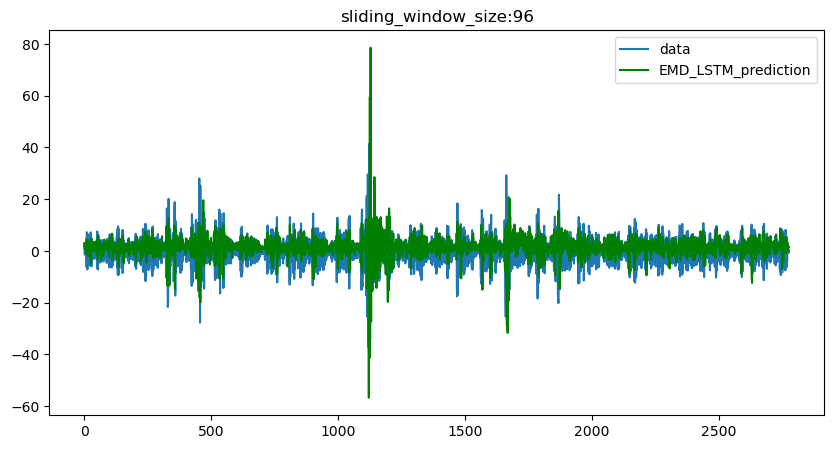

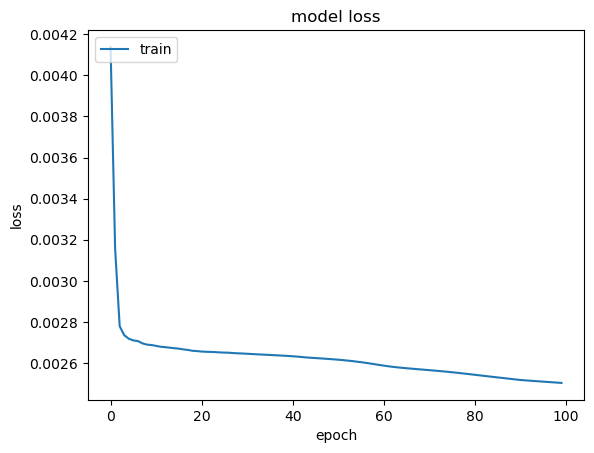

In [35]:
# 3 IMFs
result_1 = vanilla_LSTM(train_imfs[0],test_imfs[0],batch_size,epochs,look_back,1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 96, 50)            10400     
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4801      
                                                                 
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1126/1126 [==============================] - 26s 22ms/step - loss: 0.0054
Epoch 2/100
1126/1126 [==============================] - 25s 22ms/step - loss: 0.0030
Epoch 3/100
1126/1126 [==============================] - 25s 22ms/step - loss: 0.0024
Epoch 4/100
1126/1126 [==============================] -

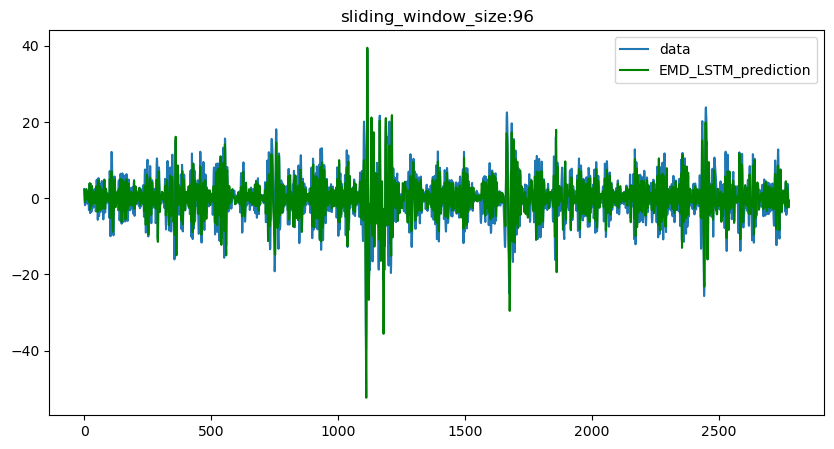

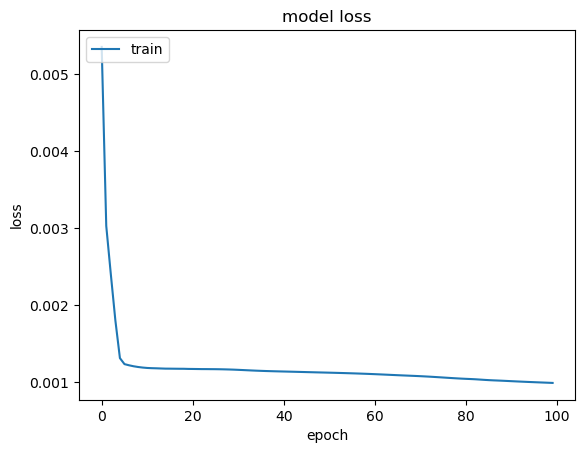

In [36]:
# 3 IMFs
result_2 = vanilla_LSTM(train_imfs[1],test_imfs[1],batch_size,epochs,look_back,2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 96, 50)            10400     
                                                                 
 flatten_2 (Flatten)         (None, 4800)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4801      
                                                                 
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1126/1126 [==============================] - 27s 23ms/step - loss: 0.0022
Epoch 2/100
1126/1126 [==============================] - 26s 23ms/step - loss: 8.8510e-04
Epoch 3/100
1126/1126 [==============================] - 26s 23ms/step - loss: 4.8524e-04
Epoch 4/100
1126/1126 [=========================

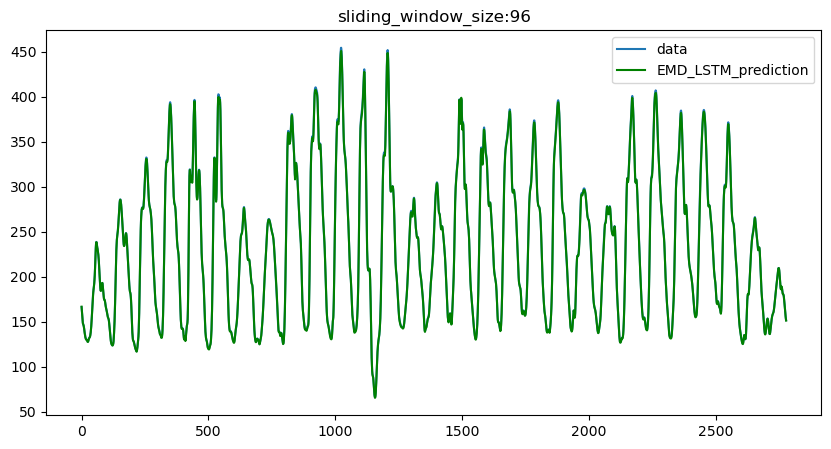

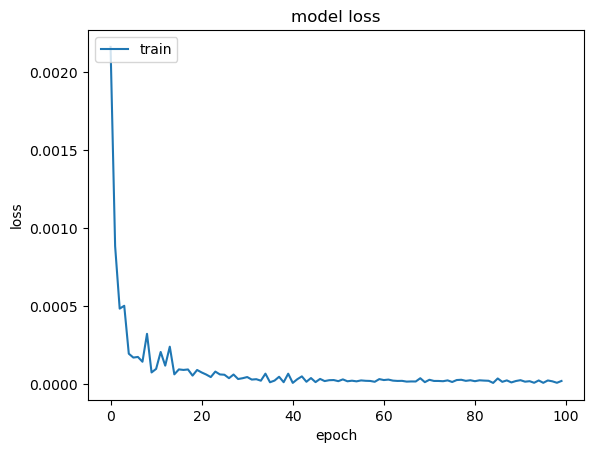

In [37]:
# 3 IMFs
result_3 = vanilla_LSTM(train_imfs[2],test_imfs[2],batch_size,epochs,look_back,3)

LSTM_R2= 0.9931425857996071
LSTM_MSE= 38.17440463370297
LSTM_MAE= 4.455915588378907
LSTM_RMSE= 6.178543892674306
LSTM_MRE= 0    2.083541
dtype: float64


C:\Users\KDDSUNFLOWER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


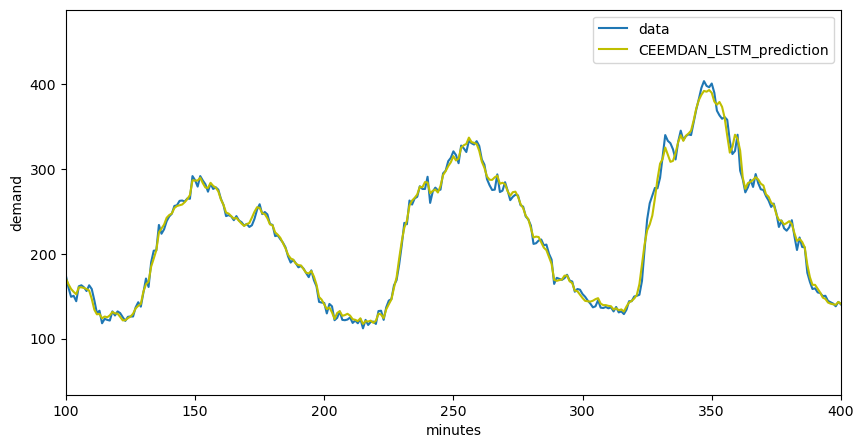

In [39]:
# 3 IMFs
result_sum = result_1 + result_2 + result_3
result_sum_dataframe = pd.DataFrame(result_sum)
scaler = MinMaxScaler(feature_range=(0,1))
test_scaled_data = scaler.fit_transform(predict_df)
x_test,y_test = createSlidingWindow(test_scaled_data,look_back)
y_test_true = scaler.inverse_transform(y_test)

LSTM_R2 = r2_score(y_test_true[100:400],result_sum_dataframe[100:400])
LSTM_MSE = mean_squared_error(y_test_true[100:400],result_sum_dataframe[100:400])
LSTM_MAE = mean_absolute_error(y_test_true[100:400],result_sum_dataframe[100:400])
LSTM_MRE = np.mean(np.abs((y_test_true[100:400] - result_sum_dataframe[100:400]) / y_test_true[100:400])) * 100
print("LSTM_R2=",LSTM_R2)
print("LSTM_MSE=",LSTM_MSE)
print("LSTM_MAE=",LSTM_MAE)
print("LSTM_RMSE=",sqrt(LSTM_MSE))
print("LSTM_MRE=",LSTM_MRE)

plt.figure(figsize=(10,5))
plt.xlim([100,400])
# plt.ylim([-100,350])
plt.ylabel("demand")
plt.xlabel("minutes")
plt.plot(y_test_true)
plt.plot(result_sum_dataframe,c='y')
# plt.title("Testing(Validation) data")
plt.legend(['data','CEEMDAN_LSTM_prediction'], loc='upper right')
plt.show()

#訓練集：2019/1/1~2021/1/1
#測試集：2021/5/1~2021/5/31

In [147]:
np.mean(np.abs((y_test_true - result_sum_dataframe) / y_test_true))

0    0.030232
dtype: float64

In [139]:
CEEMDAN_LSTM_predict = pd.DataFrame(result_sum_dataframe)
# CEEMDAN_LSTM_predict.to_csv('./Predict_result_(train_20190101_20210101_test_20210501_20210531)/CEEMDAN_LSTM_predict.csv')

LSTM_R2= 0.9898479444181858
LSTM_MSE= 34.09694868292557
LSTM_MAE= 4.430329398716774
LSTM_RMSE= 5.839259258067377


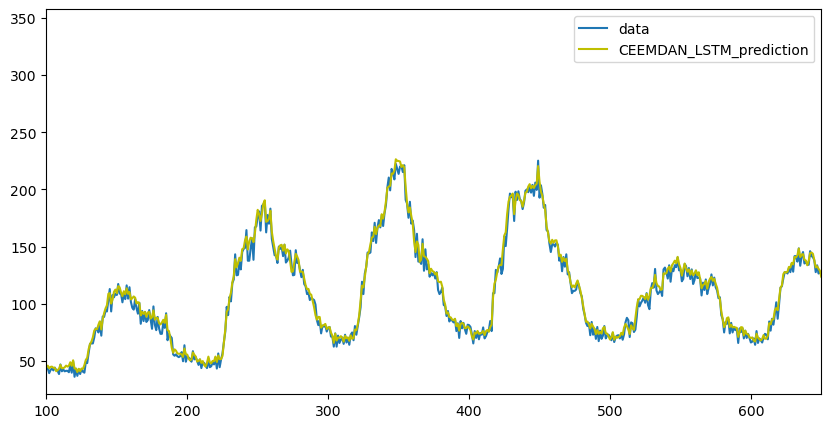

In [94]:
scaler = MinMaxScaler(feature_range=(0,1))
test_scaled_data = scaler.fit_transform(predict_df)
x_test,y_test = createSlidingWindow(test_scaled_data,look_back)
y_test_true = scaler.inverse_transform(y_test)

LSTM_R2 = r2_score(y_test_true,result_sum_dataframe)
LSTM_MSE = mean_squared_error(y_test_true,result_sum_dataframe)
LSTM_MAE = mean_absolute_error(y_test_true,result_sum_dataframe)
LSTM_MRE = np.mean(np.abs((y_test_true - result_sum_dataframe) / y_test_true)) * 100
print("LSTM_R2=",LSTM_R2)
print("LSTM_MSE=",LSTM_MSE)
print("LSTM_MAE=",LSTM_MAE)
print("LSTM_RMSE=",sqrt(LSTM_MSE))
print("LSTM_MRE=",LSTM_MRE)

plt.figure(figsize=(10,5))
plt.xlim([100,650])
# plt.ylim([-100,350])
# plt.ylabel("demand")
# plt.xlabel("minutes")
plt.plot(y_test_true)
plt.plot(result_sum_dataframe,c='y')
# plt.title("Testing(Validation) data")
plt.legend(['data','CEEMDAN_LSTM_prediction'], loc='upper right')
plt.show()

#訓練集：2021/2021/1/1~2022/1/1
#測試集：2022/5/1~2022/5/31 

LSTM_R2= 0.9540499717035945
LSTM_MSE= 154.328918333359
LSTM_MAE= 9.262304918286384
LSTM_RMSE= 12.422919074571766


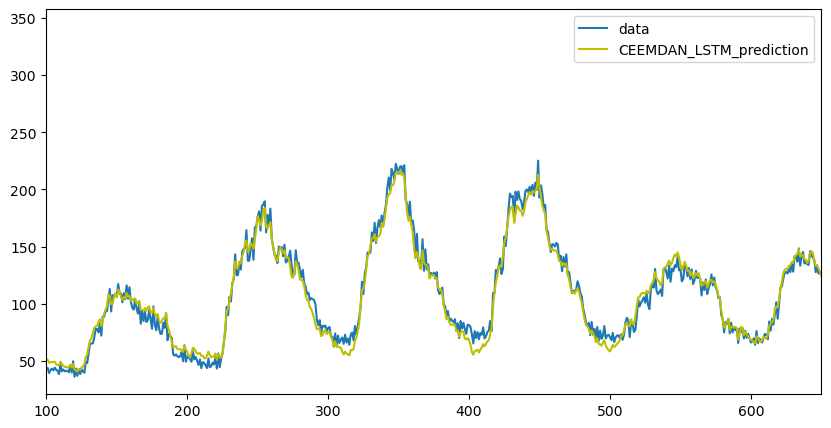

In [50]:
scaler = MinMaxScaler(feature_range=(0,1))
test_scaled_data = scaler.fit_transform(predict_df)
x_test,y_test = createSlidingWindow(test_scaled_data,look_back)
y_test_true = scaler.inverse_transform(y_test)

LSTM_R2 = r2_score(y_test_true,result_sum_dataframe)
LSTM_MSE = mean_squared_error(y_test_true,result_sum_dataframe)
LSTM_MAE = mean_absolute_error(y_test_true,result_sum_dataframe)
print("LSTM_R2=",LSTM_R2)
print("LSTM_MSE=",LSTM_MSE)
print("LSTM_MAE=",LSTM_MAE)
print("LSTM_RMSE=",sqrt(LSTM_MSE))

plt.figure(figsize=(10,5))
plt.xlim([100,650])
# plt.ylim([-100,350])
# plt.ylabel("demand")
# plt.xlabel("minutes")
plt.plot(y_test_true)
plt.plot(result_sum_dataframe,c='y')
# plt.title("Testing(Validation) data")
plt.legend(['data','CEEMDAN_LSTM_prediction'], loc='upper right')
plt.show()